In [15]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from ase.io import read
path = path = '../Examples/Molecule/'
b = 0.52917721067 #Bohr radius in Angstrom

In [19]:
def wf_plot(inpath='', plane='x', file='file'):
    def dist(x, y):
        return np.sqrt((x[0] - y[0])**2 + (x[1] - y[1])**2 + (x[2] - y[2])**2)
    
    strut = read(inpath + 'geometry.xyz')
    ele = strut.get_chemical_symbols()
    geometry = strut.positions
    colormap = {'N': 'blue', 
                'C': 'k', 
                'O': 'r', 
                'H': 'white'}
    
    bonds = []
    
    for i, x in enumerate(geometry):
        for j, y in enumerate(geometry):
            if i != j:
                if dist(x, y) < 1.6:
                    bonds.append([i, j])
    
    def rescale(x, little, big):
        return ((little - x) / (big - little)) * ((np.pi - 0.67) - (0 + 0.67)) + (np.pi - 0.67)
    
    def funky(x):
        return np.sin(x)**2
    
    def labelmaker(wf):
        wf_num = wf.split('-')[-1].split('.')[0][-2:]
        return (r"$\Psi_{%s}$" % (wf_num))
    
    if plane == 'x':
        x1 = 'Y'
        x2 = 'Z'
        pos = np.column_stack((geometry[:, 1], geometry[:, 2]))
        pre_alpha = geometry[:, 0]
        Alpha = rescale(pre_alpha, min(pre_alpha), max(pre_alpha))
    elif plane == 'y':
        x1 = 'X'
        x2 = 'Z'
        pos = np.column_stack((geometry[:, 0], geometry[:, 2]))
        pre_alpha = geometry[:, 1]
        Alpha = rescale(pre_alpha, min(pre_alpha), max(pre_alpha))
    elif plane == 'z':
        x1 = 'X'
        x2 = 'Y'
        pos = np.column_stack((geometry[:, 0], geometry[:, 1]))
        pre_alpha = geometry[:, 2]
        Alpha = rescale(pre_alpha, min(pre_alpha), max(pre_alpha))
    
    d0 = np.loadtxt(inpath + file)
    x = y = sorted(set(d0[:, 0]))
    Map = np.zeros((len(x), len(y)))
    
    for i, item in enumerate(d0):
        try:
            Map[x.index(item[0]), y.index(item[1])] = item[2]
        except Exception as e:
            pass
    
    plt.imshow(Map, cmap='viridis', extent=[min(x), max(x), min(y), max(y)], vmax=0.05, vmin=-0.05)
    cbar = plt.colorbar()
    cbar.set_label(r'$\rho(r)$ [arbs.]', fontsize=12)
    cbar.set_ticklabels([])
    
    for i, atoms in enumerate(strut):
        plt.scatter(pos[i][0] / b, pos[i][1] / b, color=colormap[ele[i]], alpha=funky(Alpha[i]), s=300, linewidth=2, edgecolor='k')
    
    for bond in bonds:
        plt.plot([pos[bond[0]][0] / b, pos[bond[1]][0] / b], [pos[bond[0]][1] / b, pos[bond[1]][1] / b], color='k', linewidth=3)
    
    plt.xlabel('%s [bohr]' % (x1), fontsize=12)
    plt.ylabel('%s [bohr]' % (x2), fontsize=12)
    plt.text(0.6 * max(x), 0.7 * max(y), labelmaker(file), fontsize=24)
    plt.show()


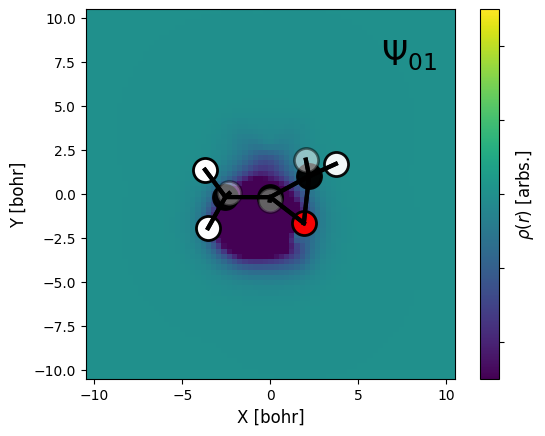

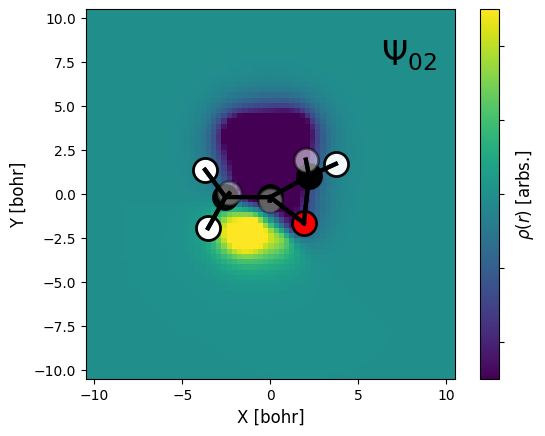

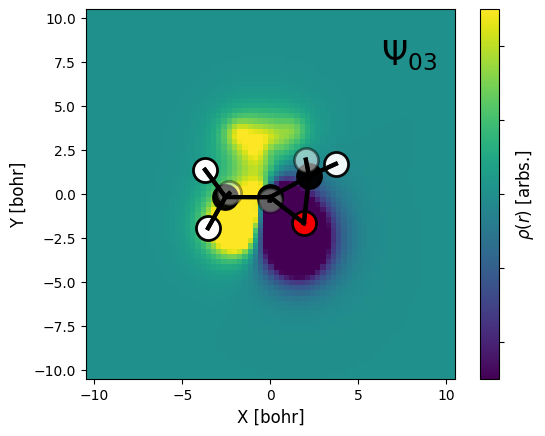

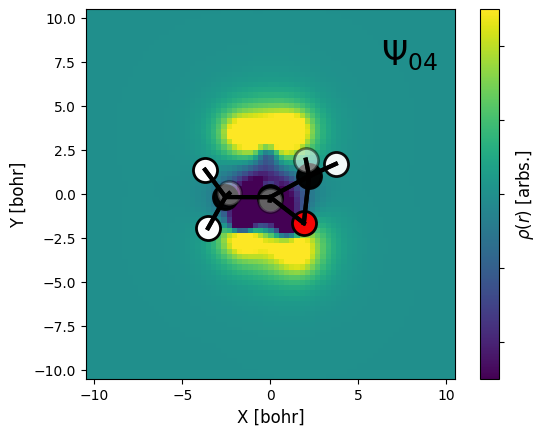

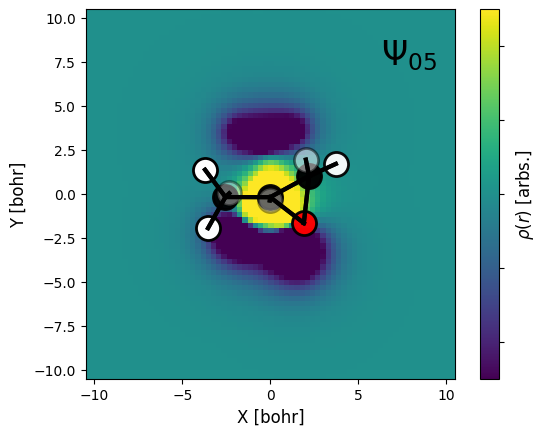

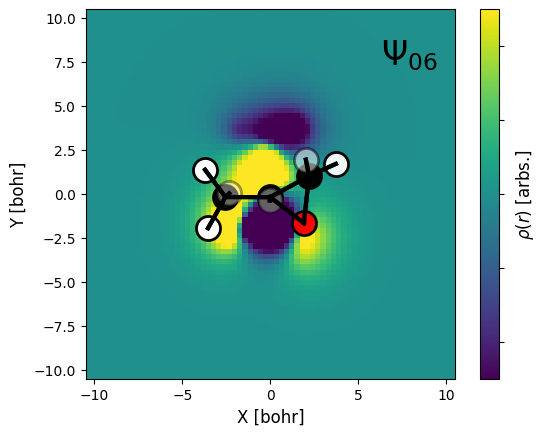

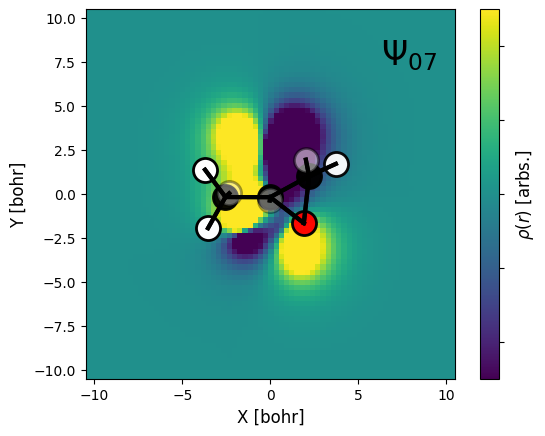

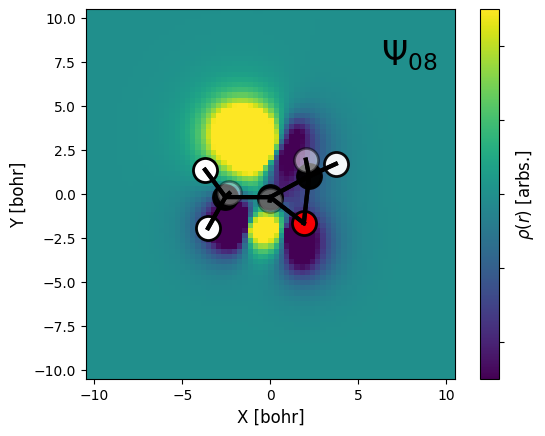

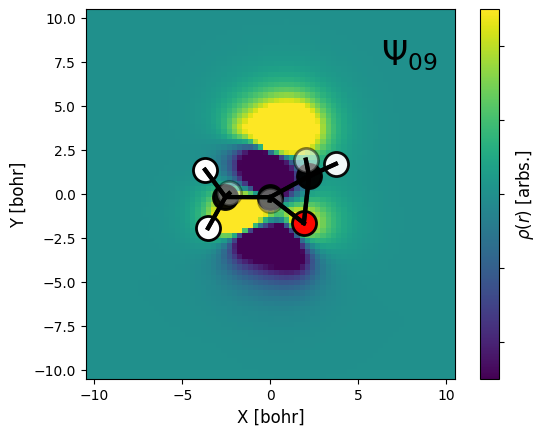

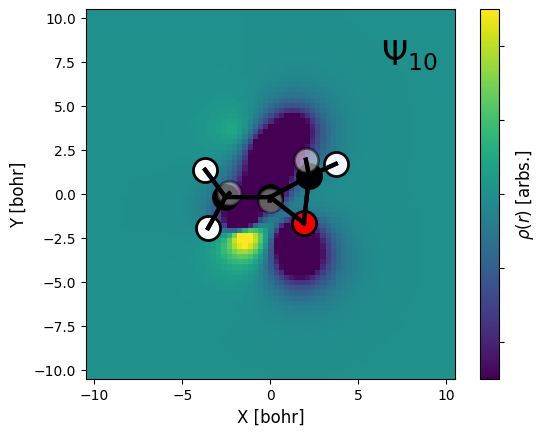

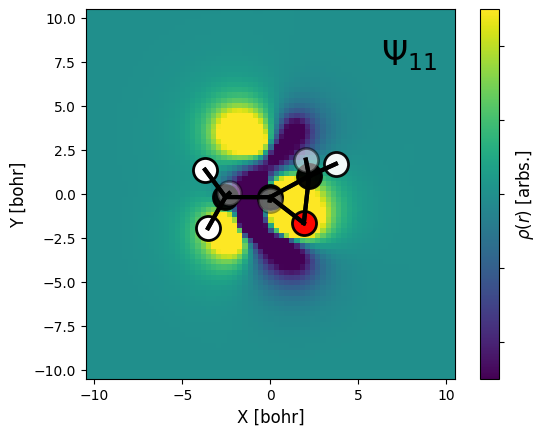

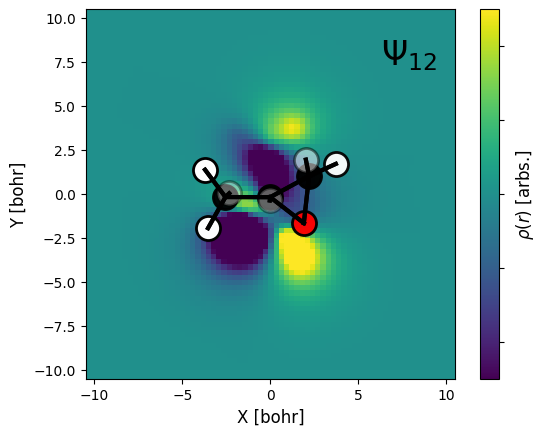

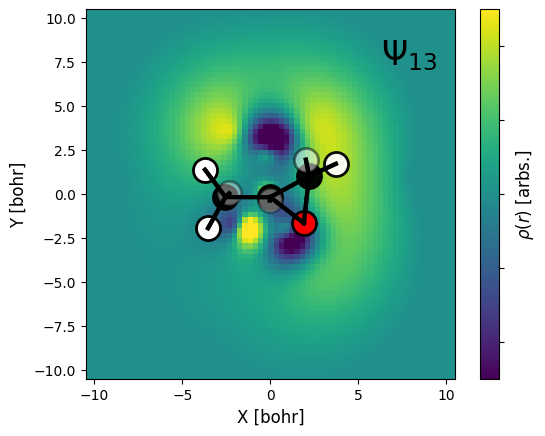

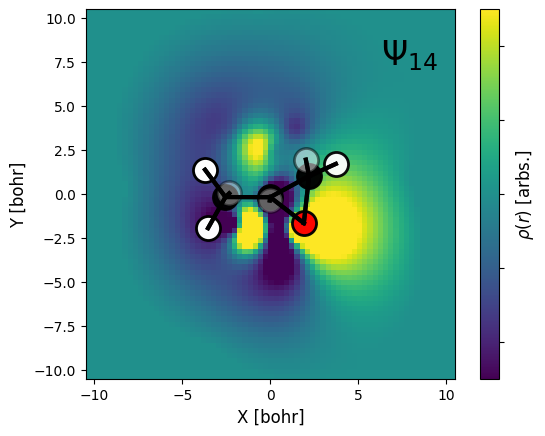

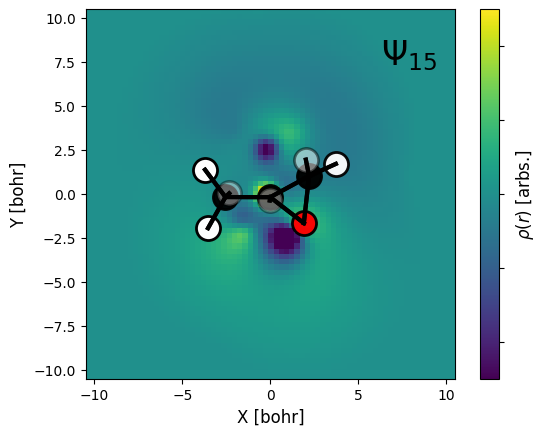

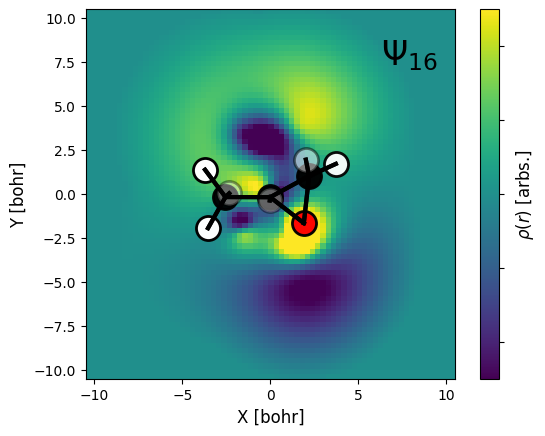

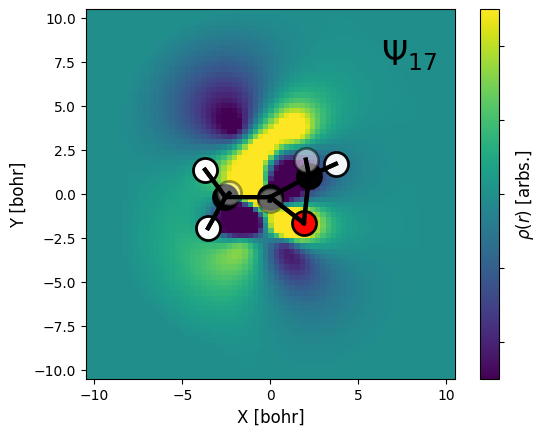

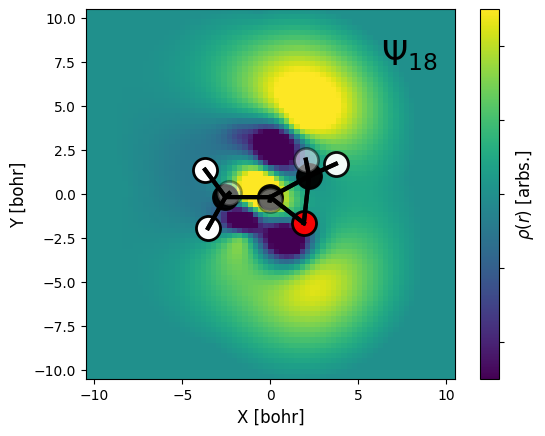

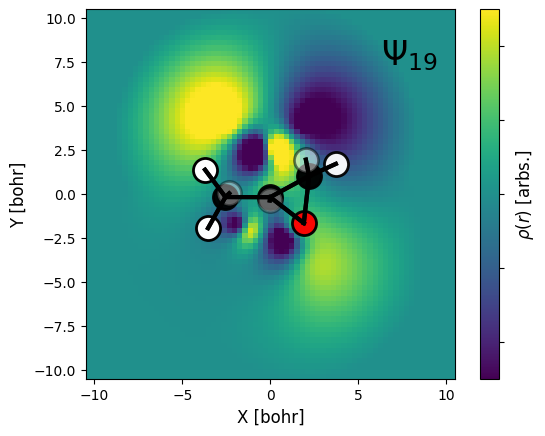

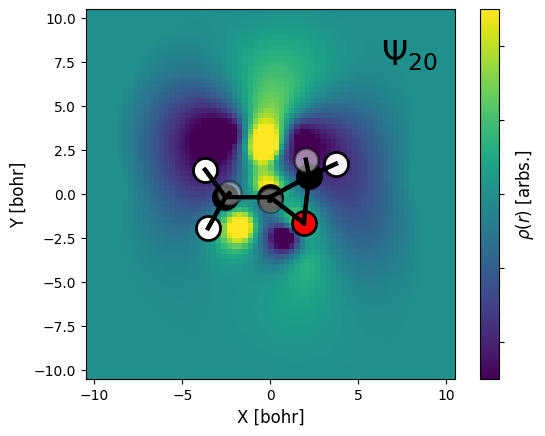

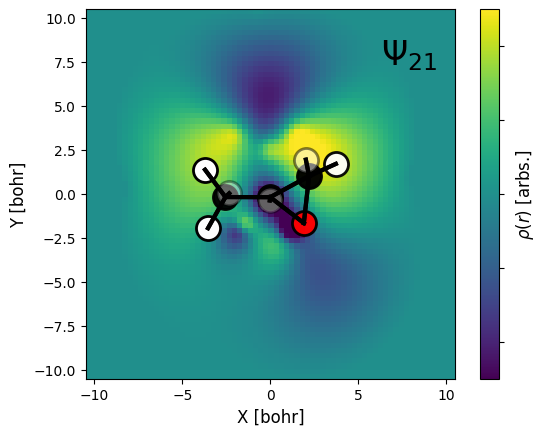

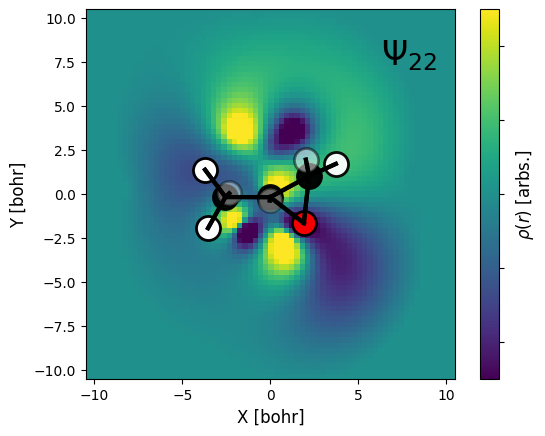

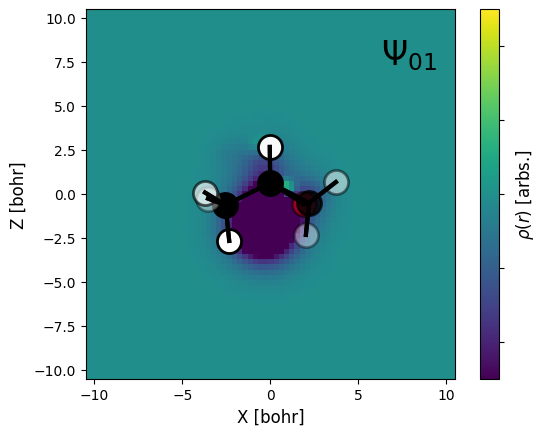

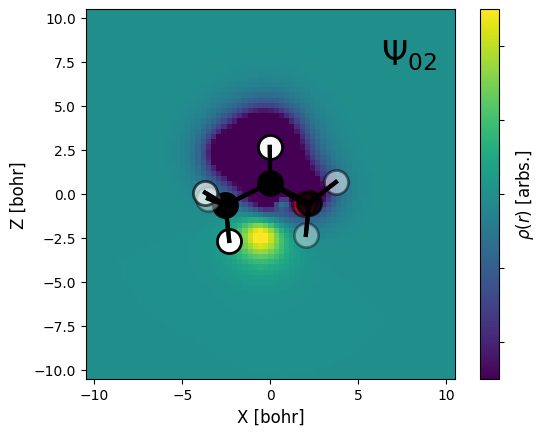

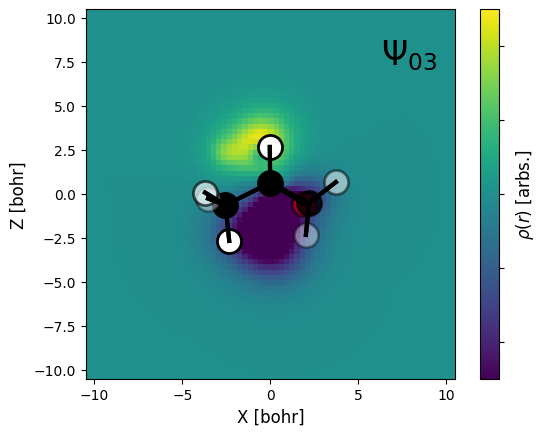

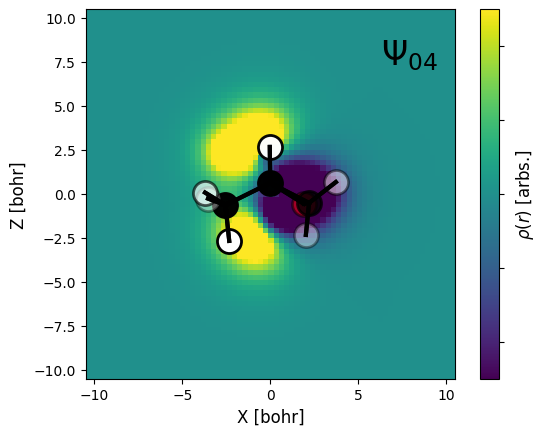

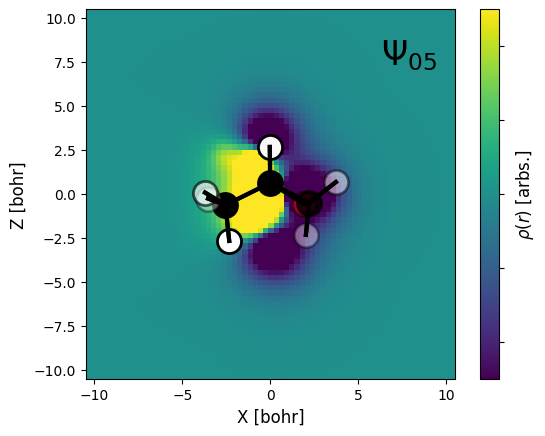

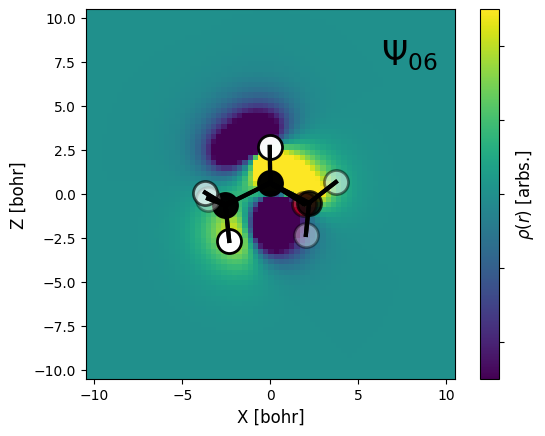

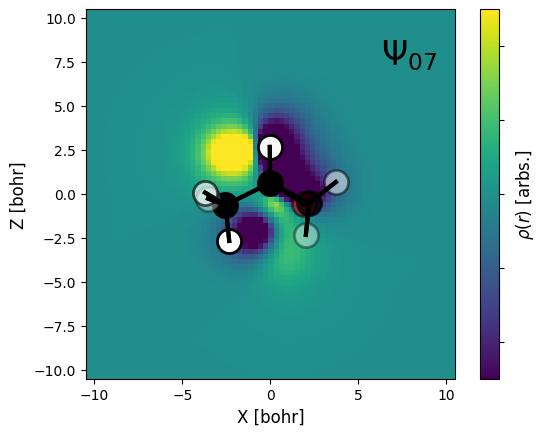

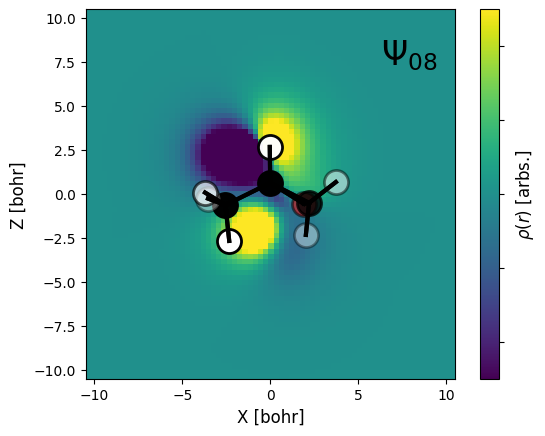

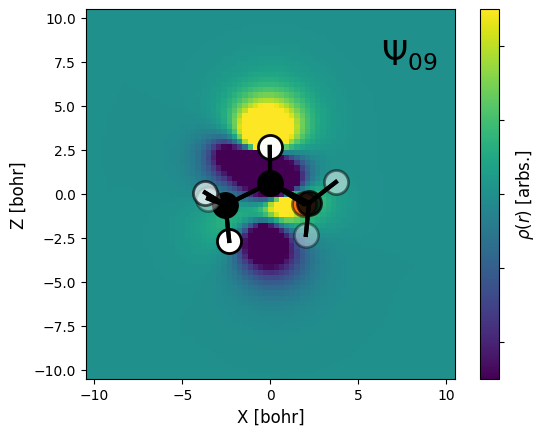

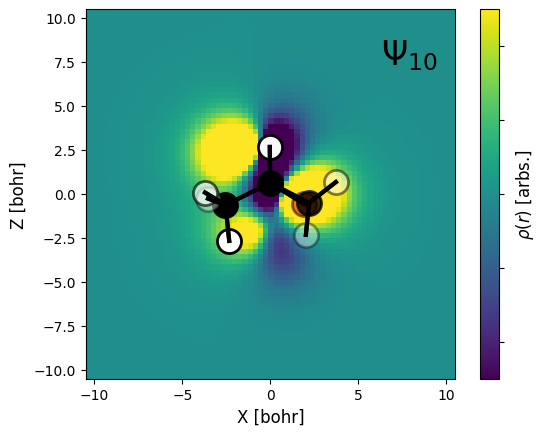

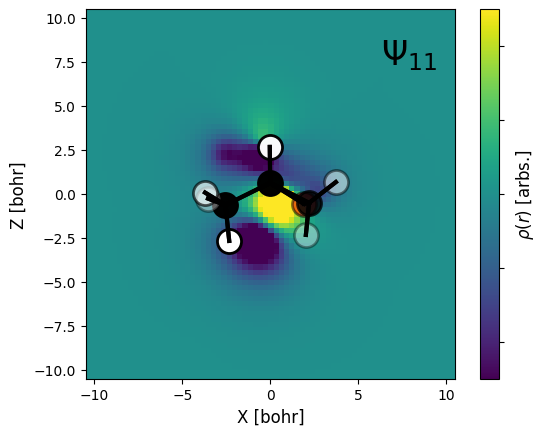

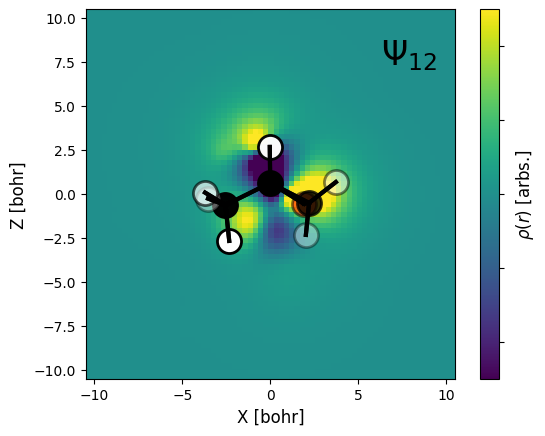

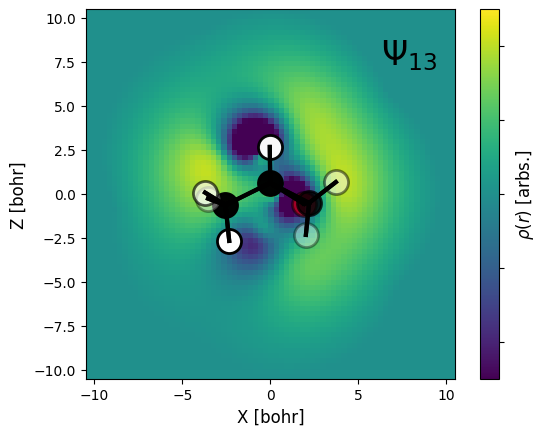

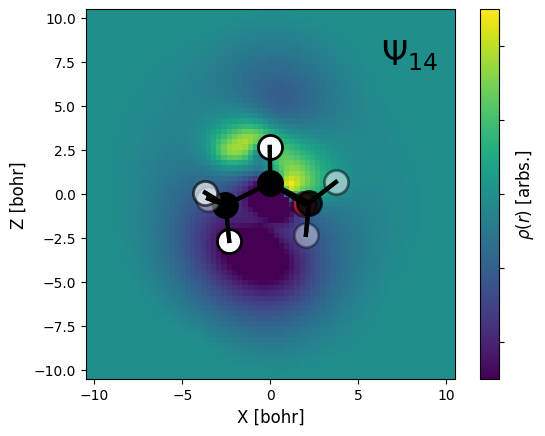

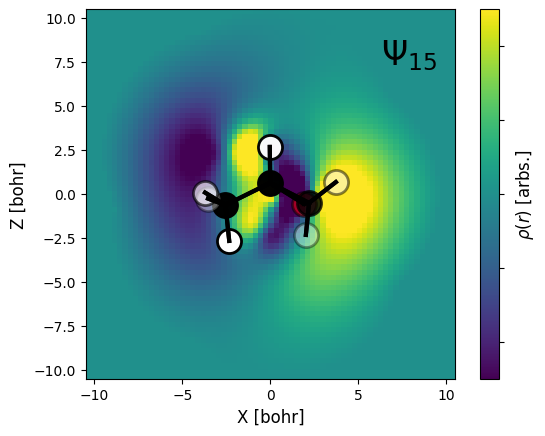

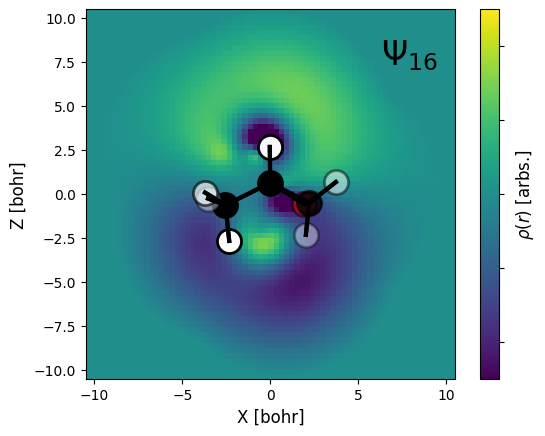

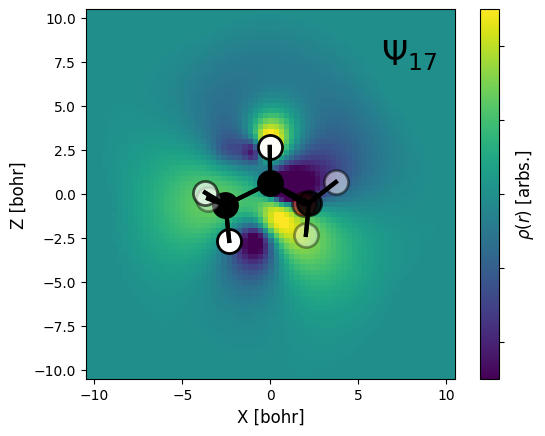

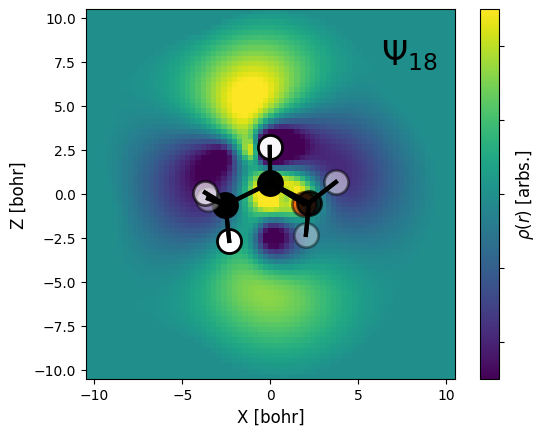

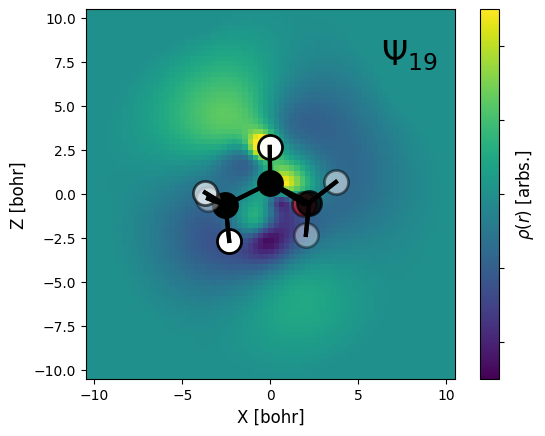

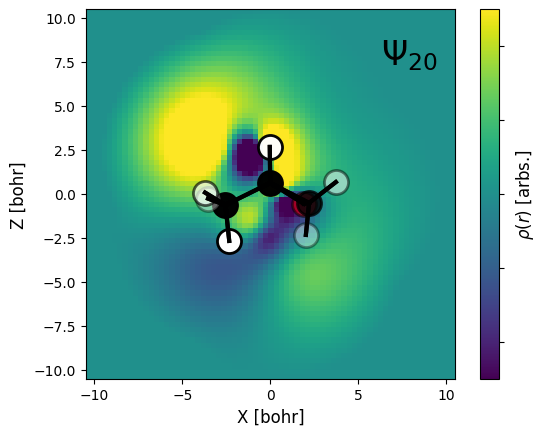

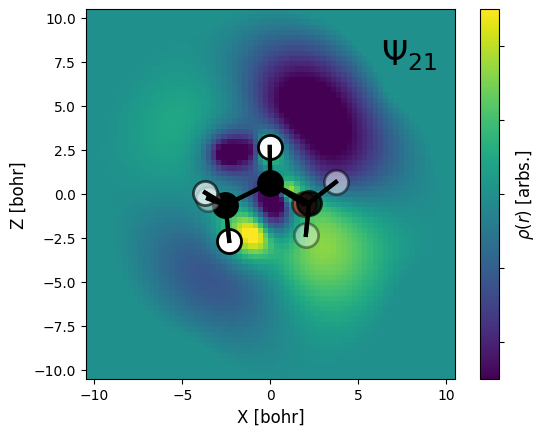

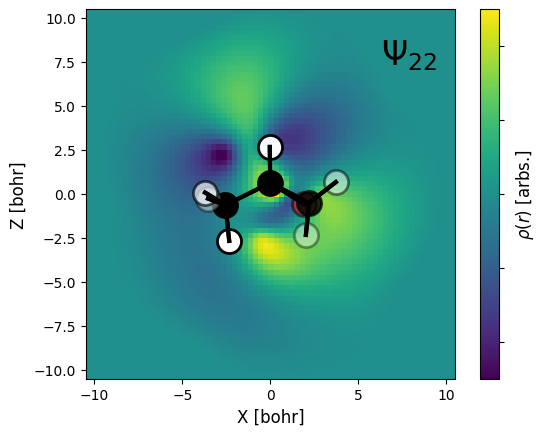

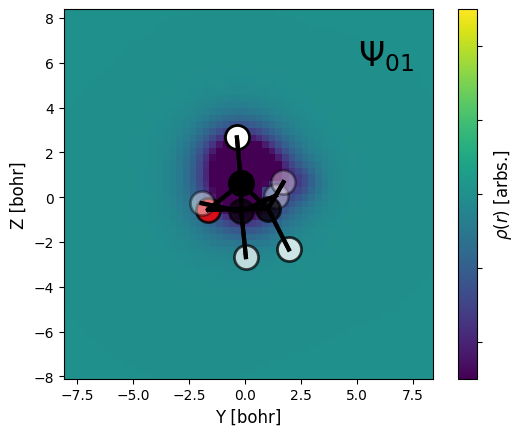

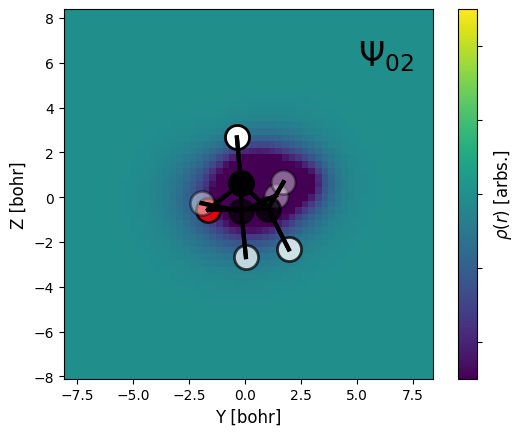

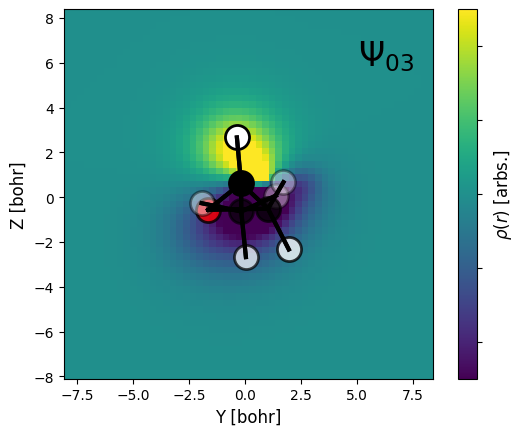

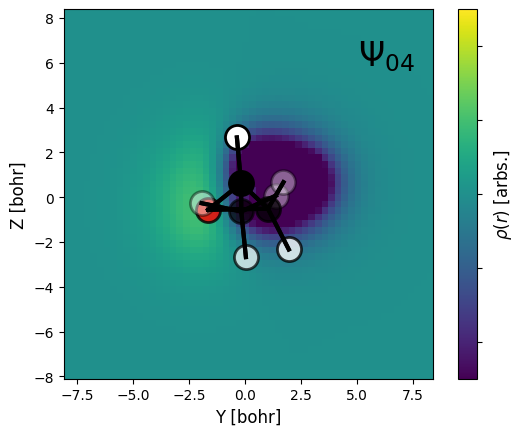

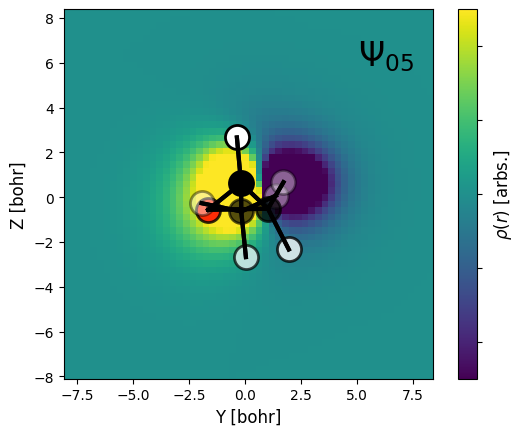

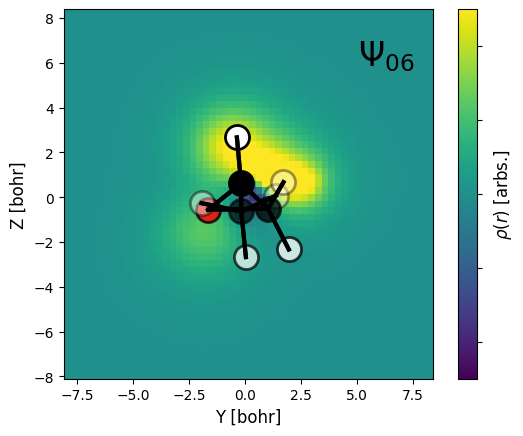

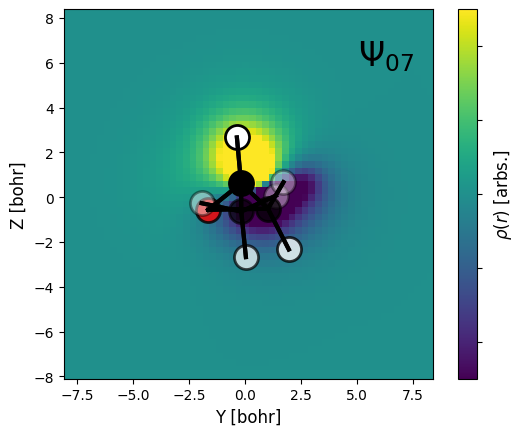

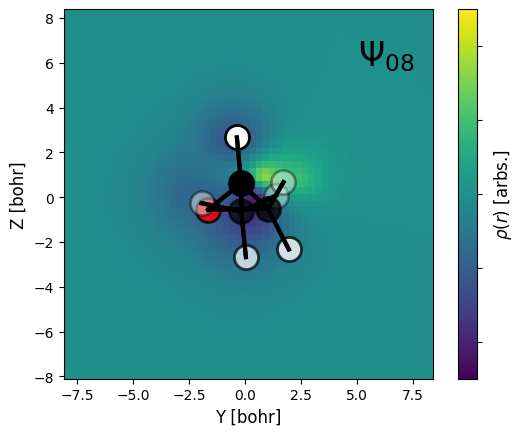

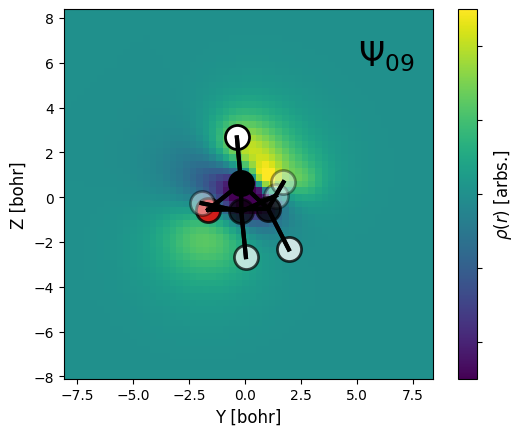

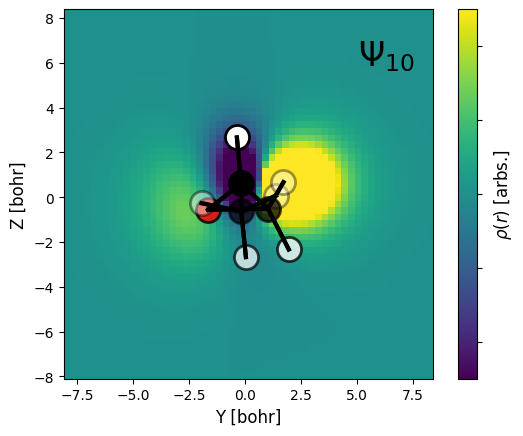

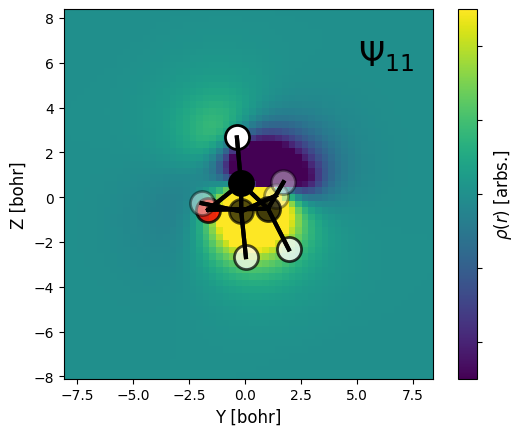

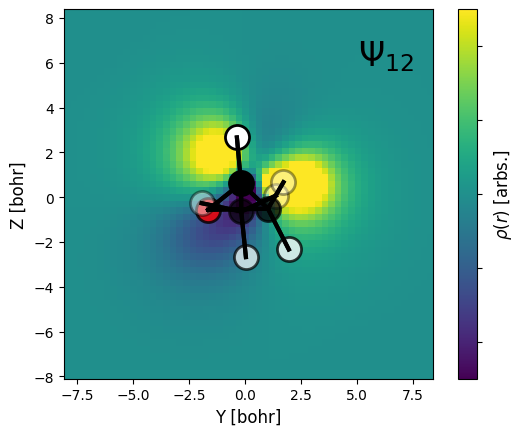

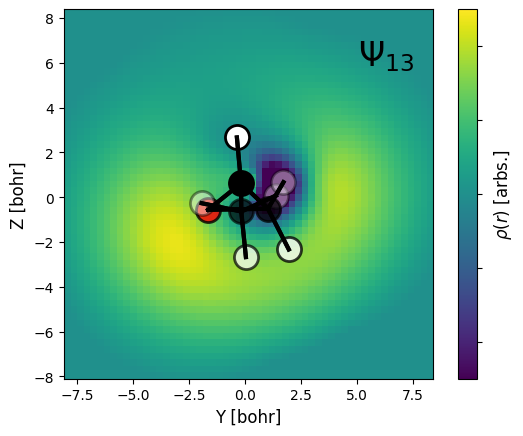

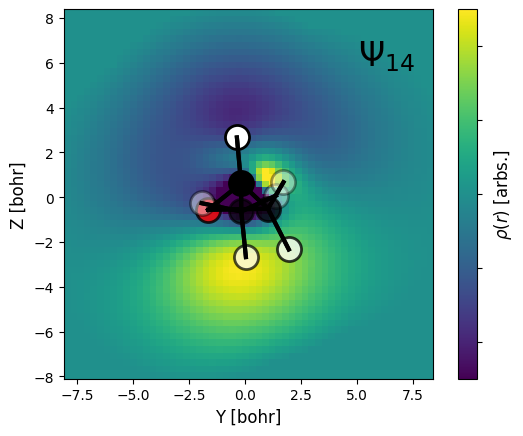

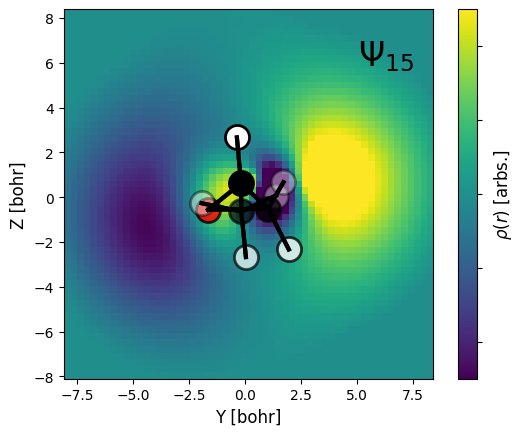

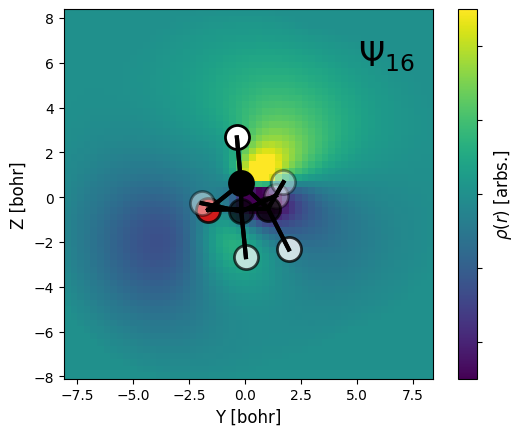

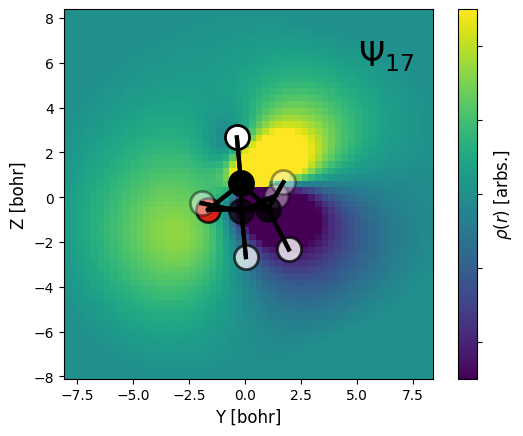

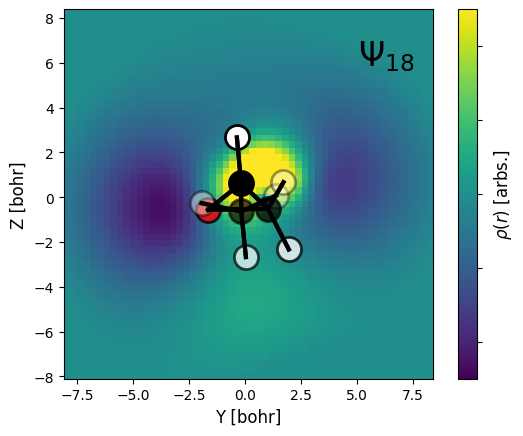

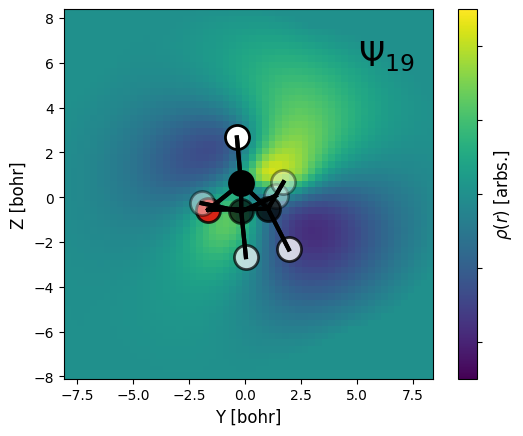

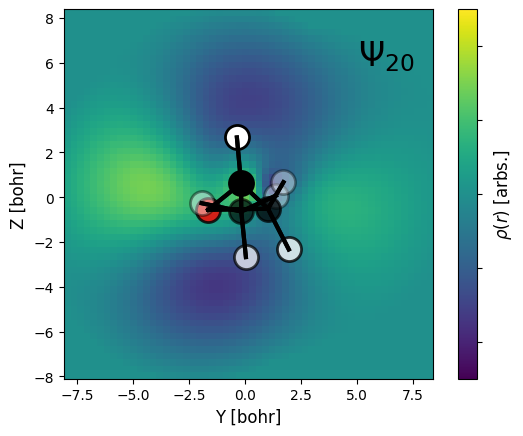

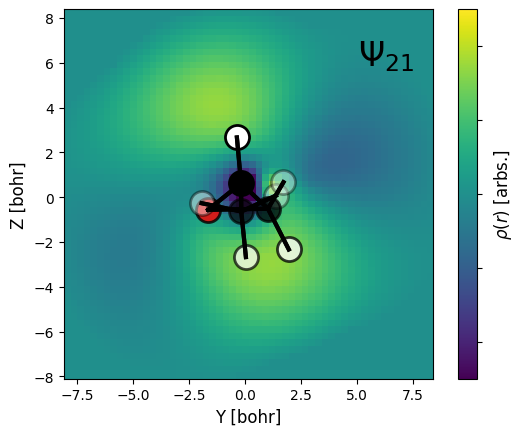

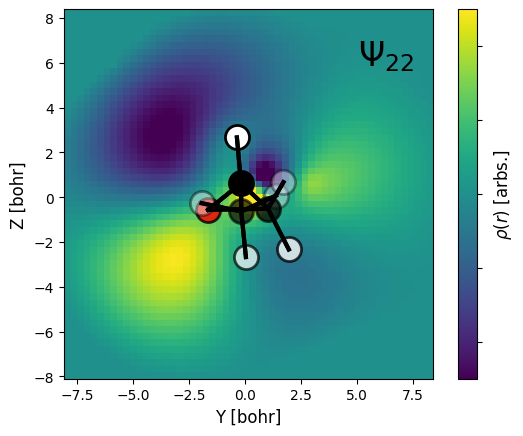

In [20]:
wfs_z = [x for i, x in enumerate(os.listdir(path + 'static/')) if (x.startswith('wf') and x.endswith('.z=0'))]
wfs_y = [x for i, x in enumerate(os.listdir(path + 'static/')) if (x.startswith('wf') and x.endswith('.y=0'))]
wfs_x = [x for i, x in enumerate(os.listdir(path + 'static/')) if (x.startswith('wf') and x.endswith('.x=0'))]
for i, wf_z in enumerate(wfs_z):
    wf_plot(path + 'static/', 'z', wf_z)
for wf_y in wfs_y:
    wf_plot(path + 'static/', 'y', wf_y)
for wf_x in wfs_x:
    wf_plot(path + 'static/', 'x', wf_x)

In [2]:
def get_dos():
    dos = np.loadtxt(path+'/static/total-dos.dat')
    ferm = np.loadtxt(path+'/static/total-dos-efermi.dat')[0][0]*27.112
    pdos = {}
    temp_pdos = [ x for i, x in enumerate(os.listdir(path+'/static/')) if x.startswith('pdos') ]
    for i, item in enumerate(temp_pdos):
        pdos[item.split('.')[0][8:]] = np.loadtxt(path+'/static/'+item)
    s_orbital_labels = ['s']
    p_orbitals_labels = ['p', 'px', 'py', 'pz']
    S = {'s' : np.zeros(500)}
    P = {'p' : np.zeros(500), 'px' : np.zeros(500), 'py' : np.zeros(500), 'pz' : np.zeros(500)}
    for key, value in pdos.items():
        if key[-1] == 's':
            S['s'] += value[:, 1]
        elif key[-1] == 'p':
            P['p'] += value[:, 1]
            P['px'] += value[:, 2]
            P['py'] += value[:, 3]
            P['pz'] += value[:, 4]
    element_contributions = {'C' : np.zeros(500),
                            'O' : np.zeros(500),
                            'H' : np.zeros(500)}
    for key, value in pdos.items():
        element = key[3]
        if element in element_contributions:
            element_contributions[element] += value[:, 1]
        else:
            element_contributions[element] = value[:, 1]
    return dos, ferm, S, P, element_contributions

In [22]:
matrix_eles = {}
for coord in ['x', 'y', 'z']:
    file_path = path + "static/ks_me_dipole.k1_" + coord
    matrix_eles[coord] = np.loadtxt(file_path)

In [29]:
D = np.sqrt(matrix_eles['x']**2 + matrix_eles['y']**2 + matrix_eles['z']**2)

In [26]:
DoS = get_dos()

In [30]:
def Big_Plot(name='BigFuckinPlot.png', save=False):

    occ = 12
    
    dos, ferm, S, P, element_contributions = DoS
    
    fig = plt.figure()
    
    fig.set_size_inches(12, 12)
    fig.set_dpi(600)
    
    ax1 = plt.subplot(221)
    im = ax1.imshow(D, cmap='viridis')
    ax1.xaxis.set_ticks_position('top')
    
    ax1.vlines(occ-1, -0.5, occ+9.5, color='k', linewidth=2, linestyles='dashed')
    ax1.hlines(occ-1, -0.5, occ+9.5, color='k', linewidth=2, linestyles='dashed')
    
    #ax1.grid(True)
    loc = plticker.MultipleLocator(base=2.0) # this locator puts ticks at regular intervals
    ax1.xaxis.set_major_locator(loc)
    ax1.yaxis.set_major_locator(loc)
    
    ax1.hlines(y=np.arange(0, occ+10)+0.5, xmin=np.full(occ+10, 0)-0.5,
               xmax=np.full(occ+10, occ+10)-0.5, color="black")
    ax1.vlines(x=np.arange(0, occ+10)+0.5, ymin=np.full(occ+10, 0)-0.5,
               ymax=np.full(occ+10, occ+10)-0.5, color="black")
    ax1.yaxis.set_label_position("left")
    ax1.xaxis.set_label_position("top")
    ax1.set_xlabel(r'$\psi_{i}$', fontsize=14)
    ax1.set_ylabel(r'$\psi_{j}$', fontsize=14)
    
    
    ax2 = plt.subplot(223)
    ax2.stackplot(dos[:,0]*27.112-ferm, S['s'], P['px'], P['py'], P['pz'],
                colors=['g',  'indianred', 'firebrick', 'darkred'],
                labels=['S', 'P$_{x}$', 'P$_{y}$', 'P$_{z}$'])
    
    ax2.plot(dos[:,0]*27.112-ferm, dos[:,1], color='k', linewidth=1.5, label='Total')
    ax2.legend(ncol=1, loc='lower right')
    ax2.set_aspect('auto')
    loc = plticker.MultipleLocator(base=4.0) # this locator puts ticks at regular intervals
    ax2.xaxis.set_major_locator(loc)
    ax2.set_ylabel('DoS (1 / eV)', fontsize=14)
    ax2.set_xlabel(r'$\varepsilon - \varepsilon_{f}$ (1 / eV)', fontsize=14)
    ylims = ax2.get_ylim()
    ax2.vlines(0. *27.112, ylims[0], ylims[1], color='k', linestyle='--', linewidth=1, alpha=0.5)
    ax2.set_ylim(ylims[::-1])
    
    
    ax3 = plt.subplot(222)
    colors = {'C': 'tab:blue', 'O': 'tab:red', 'H': 'tab:green'}
    ax3.yaxis.tick_right()
    ax3.yaxis.set_label_position("right")
    # Plot the stacked area plot
    polys = ax3.stackplot(dos[:,0]*27.112-ferm,  element_contributions.values(), labels=element_contributions.keys(), colors=colors.values())
    xlims = ax3.get_xlim()
    ylims = ax3.get_ylim()
    for poly in polys:
        for Path in poly.get_paths():
            Path.vertices = Path.vertices[:, ::-1]
    ax3.set_xlim(ylims)  # use old y limitsrobert.m.jom
    ax3.set_ylim(xlims[::-1])  # use old x limits, reversed
    ax3.plot(dos[:,1], dos[:,0]*27.112-ferm, color='k', linewidth=1.5, label='Total')
    loc = plticker.MultipleLocator(base=4.0) # this locator puts ticks at regular intervals
    ax3.yaxis.set_major_locator(loc)
    # Set the x-axis label
    ax3.set_ylabel(r'$\varepsilon - \varepsilon_{f}$ (1 / eV)', fontsize=14)
    ax3.set_aspect('auto')
    # Set the y-axis label
    ax3.set_xlabel('DoS (1 / eV)', fontsize=14)
    ax3.legend(ncol=4)

    ax3.hlines(0. *27.112, ylims[0], ylims[1], color='k', linestyle='--', linewidth=1, alpha=0.5)
    
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    
    ax4 = fig.add_axes([0.55, 0.4, 0.33, 0.033])
    fig.colorbar(im, label=r'$\langle \hat{D} \rangle$ [bohr]', cax=ax4, shrink=0.67, orientation='horizontal')
    
    if save:
        plt.savefig(path+name, dpi=600, bbox_inches='tight')
        
    plt.show()

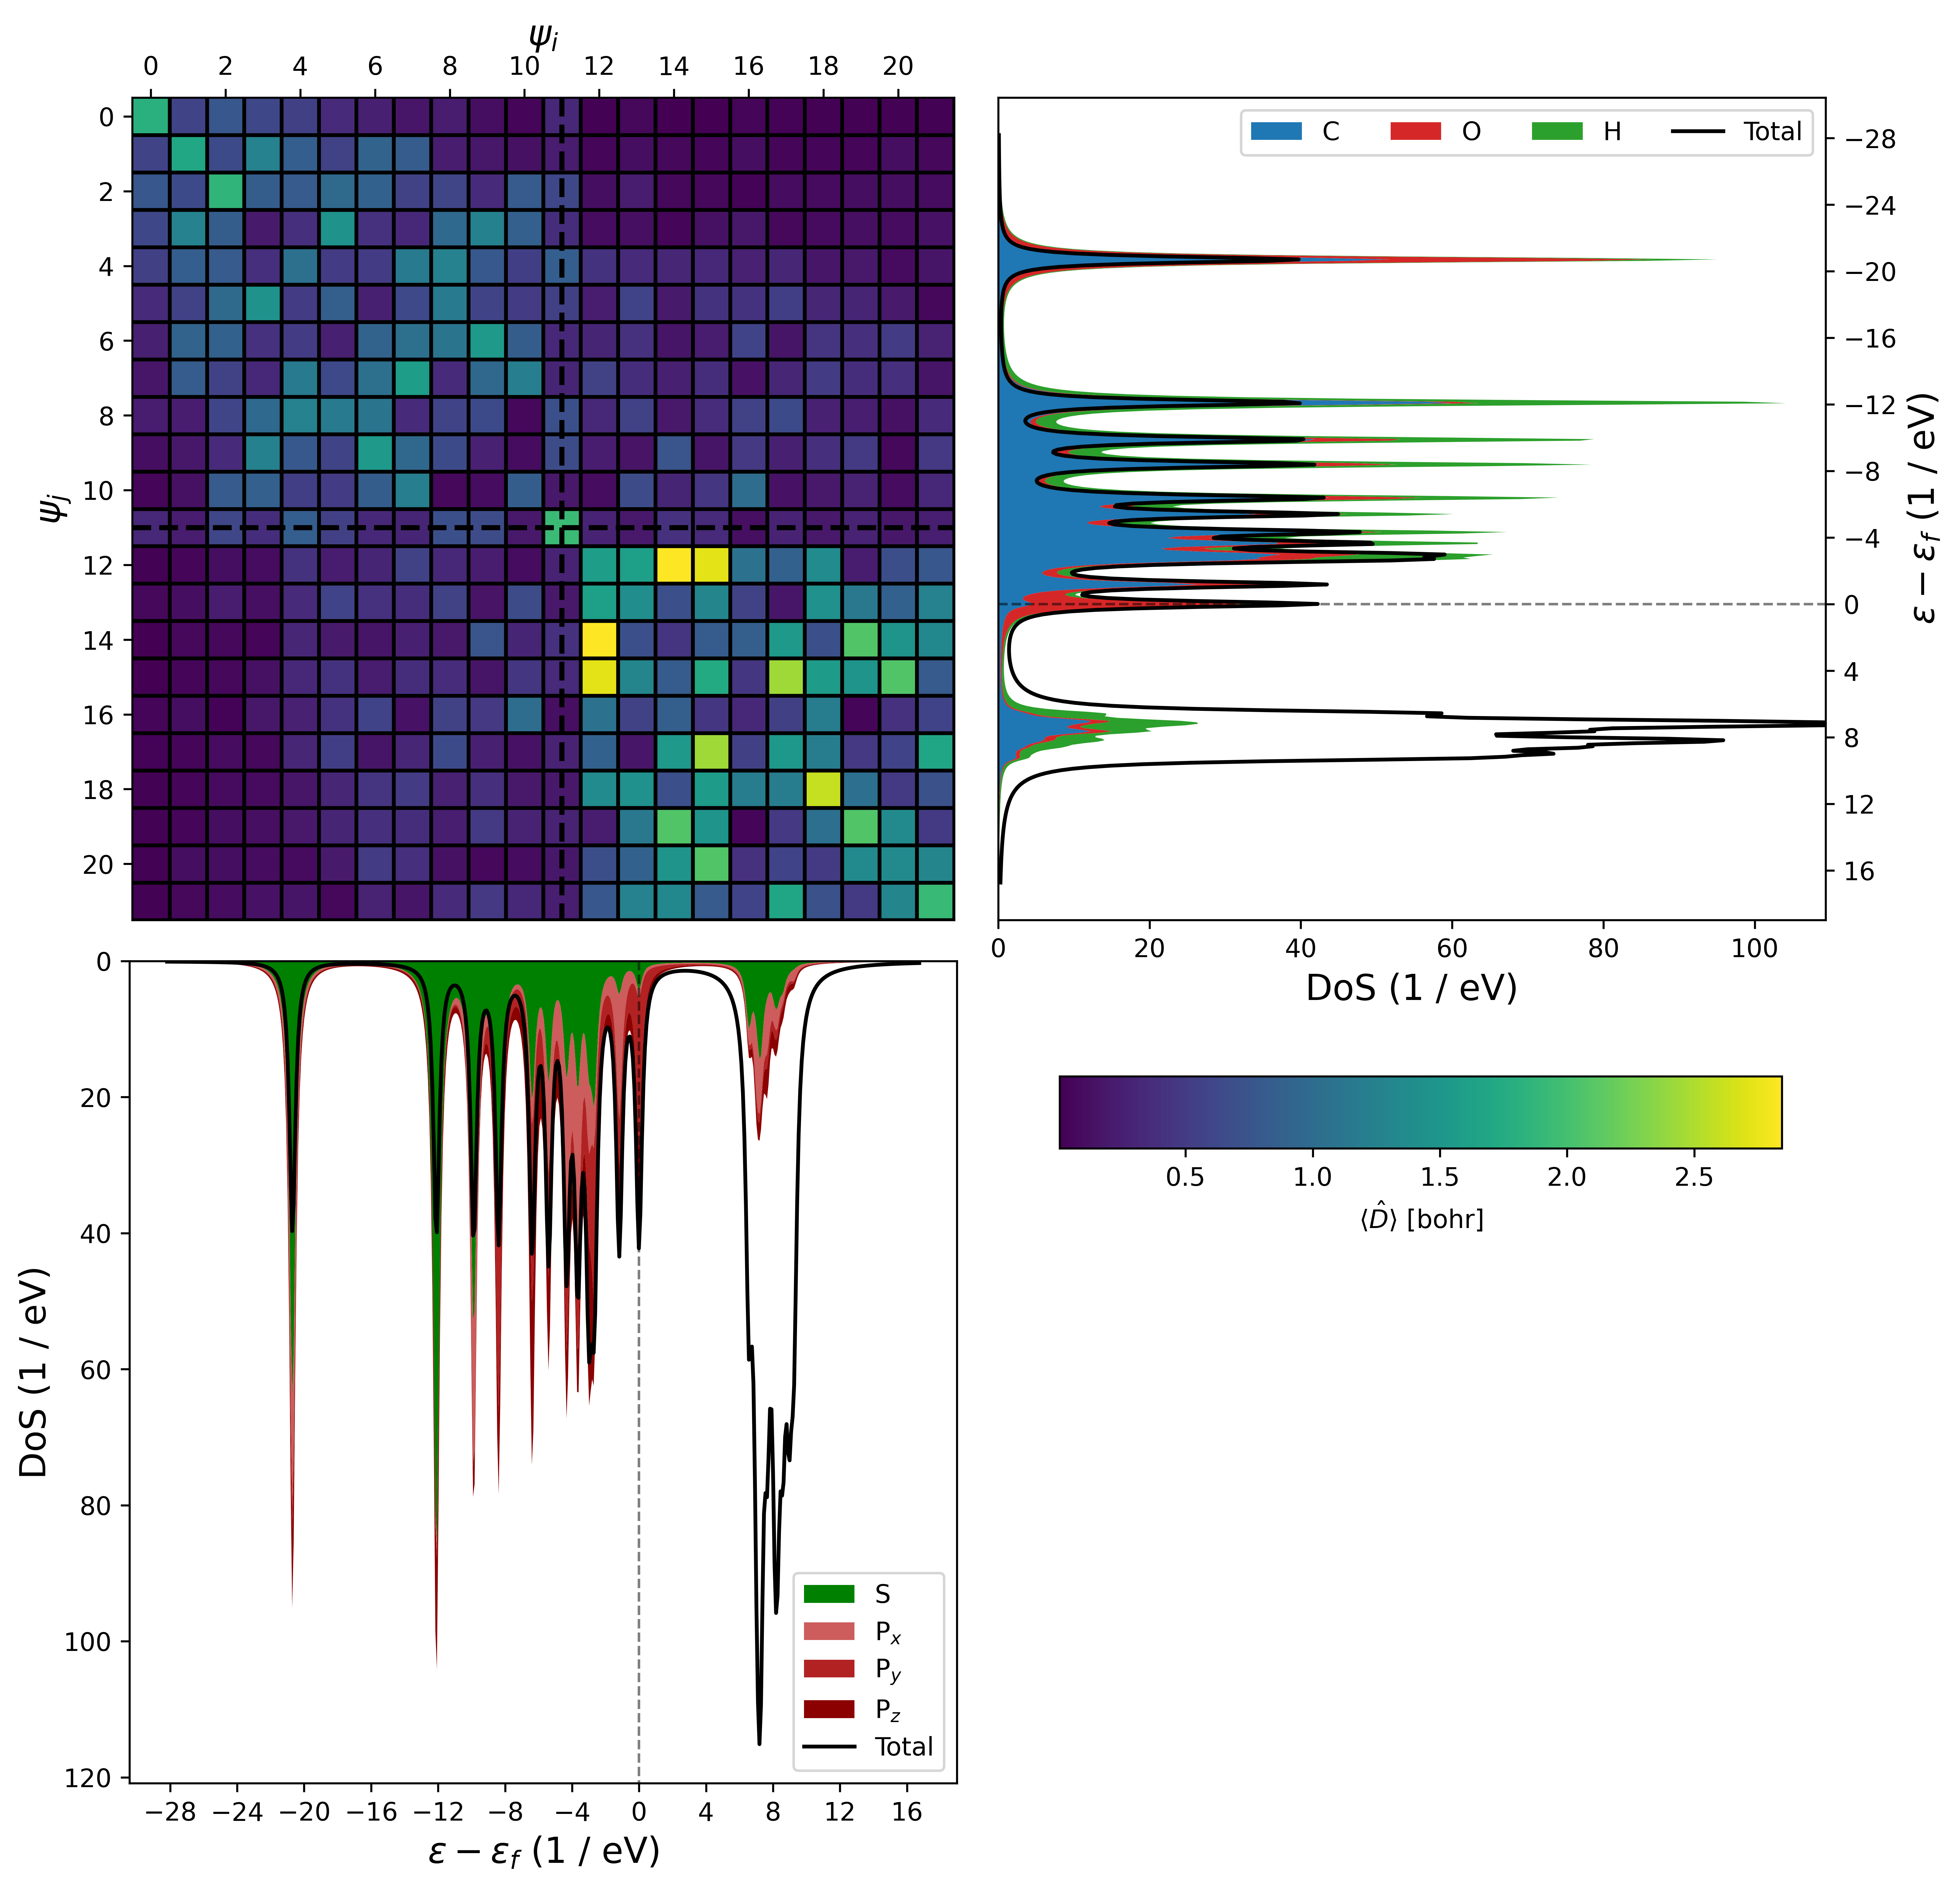

In [31]:
Big_Plot(save=False)